In [1]:
import os
import csv
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [32]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
# define the paths to the dataset and the CSV file
base_path = "newww_dataset"

classes = {
    "Infarction": {"rest": "Infarction/rest", "stress": "Infarction/stress"},
    "Ischemia": {"rest": "Ischemia/rest", "stress": "Ischemia/stress"},
    "Normal": {"rest": "Normal/rest", "stress": "Normal/stress"}
}

In [4]:
#define the id of the patients
def get_patient_id(filename):
    try:
        return int(filename.split('_')[0].replace('patient', ''))
    except (ValueError, IndexError):
        return None

In [5]:
import os
import csv
for class_name, paths in classes.items():
    csv_filename = f"{class_name}_images.csv"
    with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Patient_ID", "Image_Type", "File_Path"])
        
        for image_type, folder in paths.items():
            folder_path = os.path.join(base_path, folder)
            if not os.path.exists(folder_path):
                print(f"Folder {folder_path} does not exist!")
                continue
            
            files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]
            for file in files:
                patient_id = get_patient_id(file)
                if patient_id is not None:
                    full_path = os.path.join(folder_path, file)
                    writer.writerow([patient_id, image_type, full_path])
    
    print(f" CSV file {csv_filename} has been created successfully!")

 CSV file Infarction_images.csv has been created successfully!
 CSV file Ischemia_images.csv has been created successfully!
 CSV file Normal_images.csv has been created successfully!


In [6]:
# Load images and preprocess them
def load_images(csv_file, target_size=(224, 224)):
    data = []
    labels = []
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # تخطي العنوان
        for row in reader:
            patient_id, image_type, file_path = row
            img = load_img(file_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0
            data.append((patient_id, image_type, img_array))
            labels.append(class_name)
    return data, labels

In [7]:
def build_two_input_cnn(input_shape=(224, 224, 3)):
    # REST branch
    rest_input = Input(shape=input_shape, name='rest_input')
    x1 = Conv2D(16, (3, 3), activation='relu')(rest_input)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = GlobalAveragePooling2D()(x1)
    # STRESS branch
    stress_input = Input(shape=input_shape, name='stress_input')
    x2 = Conv2D(16, (3, 3), activation='relu')(stress_input)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(32, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = GlobalAveragePooling2D()(x2)
    

	 # Combine branches
    
    combined = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(combined)
    output = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=[rest_input, stress_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
data = []
labels = []
for class_name in classes:
    csv_file = f"{class_name}_images.csv"
    class_data, class_labels = load_images(csv_file)
    data.extend(class_data)
    labels.extend(class_labels)

patient_data = {}
for (pid, img_type, img_array), label in zip(data, labels):
    if pid not in patient_data:
        patient_data[pid] = {'rest': None, 'stress': None, 'label': label}
    patient_data[pid][img_type] = img_array

In [9]:
rest_images = []
stress_images = []
y = []
class_map = {'Infarction': 0, 'Ischemia': 1, 'Normal': 2}
for pid, info in patient_data.items():
    if info['rest'] is not None and info['stress'] is not None:
        rest_images.append(info['rest'])
        stress_images.append(info['stress'])
        y.append(class_map[info['label']])

rest_images = np.array(rest_images)
stress_images = np.array(stress_images)
y = np.eye(3)[y]  # One-hot encoding

In [10]:
# Split the data into training and testing sets
X_rest_train, X_rest_test, X_stress_train, X_stress_test, y_train, y_test = train_test_split(
    rest_images, stress_images, y, test_size=0.2, random_state=42
)

In [23]:
# Build and train the model
model = build_two_input_cnn()
model.fit([X_rest_train, X_stress_train], y_train, validation_split=0.1, epochs=15, batch_size=8)

Epoch 1/15
106/106 [==============================] - 6s 43ms/step - loss: 0.8600 - accuracy: 0.6033 - val_loss: 0.5215 - val_accuracy: 0.7553
Epoch 2/15
106/106 [==============================] - 4s 40ms/step - loss: 0.5586 - accuracy: 0.7162 - val_loss: 0.5334 - val_accuracy: 0.6383
Epoch 3/15
106/106 [==============================] - 4s 41ms/step - loss: 0.4915 - accuracy: 0.7613 - val_loss: 0.4454 - val_accuracy: 0.8085
Epoch 4/15
106/106 [==============================] - 4s 41ms/step - loss: 0.4617 - accuracy: 0.7803 - val_loss: 0.5207 - val_accuracy: 0.8191
Epoch 5/15
106/106 [==============================] - 4s 40ms/step - loss: 0.4807 - accuracy: 0.7850 - val_loss: 0.3991 - val_accuracy: 0.8191
Epoch 6/15
106/106 [==============================] - 4s 39ms/step - loss: 0.4421 - accuracy: 0.7981 - val_loss: 0.3956 - val_accuracy: 0.8298
Epoch 7/15
106/106 [==============================] - 4s 39ms/step - loss: 0.3950 - accuracy: 0.8361 - val_loss: 0.3996 - val_accuracy: 0.8085

In [24]:
loss, accuracy = model.evaluate([X_rest_test, X_stress_test], y_test,batch_size=4)
print(f"TEST ACC: {accuracy:.2f}")

59/59 [==============================] - 1s 9ms/step - loss: 0.1696 - accuracy: 0.9231
TEST ACC: 0.92


59/59 [==============================] - 1s 8ms/step
✅ Confusion matrix saved as 'confusion_matrix.png'


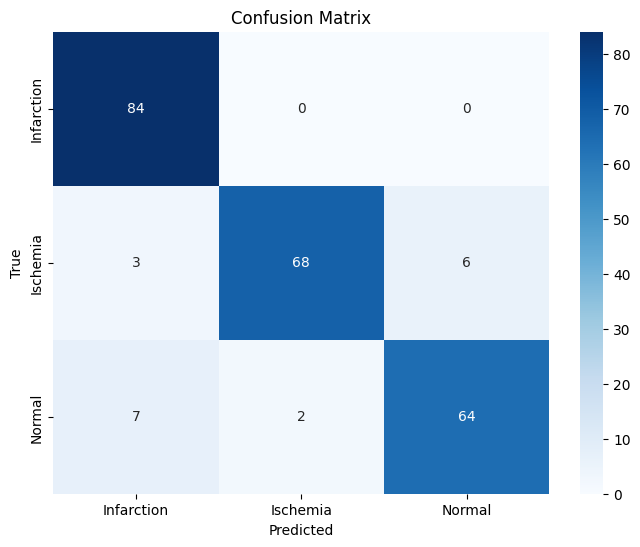

In [33]:
#drow the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting using the model
y_pred = model.predict([X_rest_test, X_stress_test], batch_size=4)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Infarction', 'Ischemia', 'Normal'],
            yticklabels=['Infarction', 'Ischemia', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
print("✅ Confusion matrix saved as 'confusion_matrix.png'")

